In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
using ForwardDiff
using JuMP
using COSMO
using ECOS
using Random; 
using PyPlot

  Activating environment at `~/SSD/Code/Julia/tinympc-dev-julia/rocket_landing_Zac/Project.toml`


In [61]:
# Let's solve TrajOpt first
include("mpc_JuMP.jl")
include("tinyMPC.jl")

nx = 6
nu = 3
N = 301
dt = 0.05

affine = 1  # SOLVE AFFINE DYNAMICS

A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]*affine
# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    # State is x, y, z, vx, vy, vz
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f*affine
end

discrete_dynamics (generic function with 1 method)

In [ ]:
Q = 1e2*I(nx)
R = 1e0*I(nu)
Qf = 1e2*I(nx)

gravity = [0; 0; -9.81]
mass = 10.0
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax

# Sloppy bound to test
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# Sloppy bound to test
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

# References
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 3, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
for k = 1:N
    # Xref[k] = x0 + (xg - x0)*(k-1)/(N-1)
    Xref[k] = xg*1
  end
Uref = [[0, 0, 10.] for i = 1:N-1]

ncx = 2*nx*0  # Replace 1 with 0 to ignore this constraint
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*1;  # Not used now
cone_scale = 1e-3  

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
# uguess = [0; 0; 10.0]
# U = [deepcopy(uguess) for k = 1:N-1]  # initial guess 
U = deepcopy(Uref)
# new iterate

Xn = deepcopy(X)
Un = deepcopy(U)
P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

optimizers = (
    JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-2,
        "rho"=>1e2,
        "scaling"=>0,
        "alpha"=>1.0,
        "max_iter" => 1000),
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false, "abstol"=>1e-2, "max_iters" => 2000)) 
    # JuMP.optimizer_with_attributes(ECOS.Optimizer, 
    # "verbose"=>false,
    # "feastol"=>1e-4,
    # "abstol"=>1e-4,
    # "reltol"=>1e-4)) 
# Solve with other solver
mpc_JuMP(optimizers[1], params, Xn, Un, A, B, f; warm_start=false)

# Solve with tinyMPC
# u_ = tiny_solve!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=100,max_inner_iters=10, verbose=false,ρ=1e0,ρ_max=1e10, ϕ=10.0);

In [ ]:
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
Xref_m = mat_from_vec(Xref)
fig = plt.figure()
plot(Xref_m[1,:]) # z
plot(Xsim_m[1,:])
plot(Xref_m[2,:]) # z
plot(Xsim_m[2,:])
plot(Xref_m[3,:]) # z
plot(Xsim_m[3,:])
# put limit on axis
plt.ylim(-5, 20)
plt.xlim(0, 300)
fig
# using Plots
# display(plot(Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
#              title = "State History",
#              xlabel = "time (s)", ylabel = "x"))
# display(plot(Usim_m',label = ["u₁" "u₂" "u₃"],
#              title = "Input History",
#              xlabel = "time (s)", ylabel = "u"))

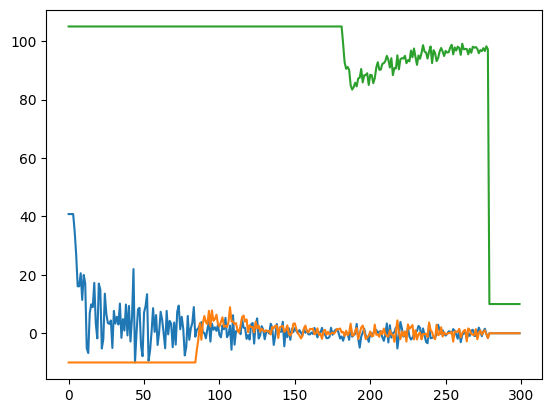

In [71]:
fig = plt.figure()
plot(Usim_m[1,:])
plot(Usim_m[2,:])
plot(Usim_m[3,:])
fig

In [ ]:
# Xsim_m = mat_from_vec(Xn)
# Usim_m = mat_from_vec(Un)
# using Plots
# display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
#              title = "State History",
#              xlabel = "time (s)", ylabel = "x"))
# display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
#              title = "Input History",
#              xlabel = "time (s)", ylabel = "u"))

In [ ]:
# @show params.λ'*X[NHORIZON]
# X[NHORIZON]
# # params.μx
# convio = 0.0
# if params.ncx > 0
#   for k = 1:NHORIZON
#     hxv = ineq_con_x(params,X[k])
#     mask = eval_mask(μx[k],hxv)
#     # update dual
#     convio = max(convio,norm(hxv + abs.(hxv),Inf)) 
#     @show params.μx[k]'*hxv  # Test Complementarity         
#   end
# end

In [ ]:
# # Reference for the next MPC problem
# Xref .= Xn;
# Uref .= Un;

In [93]:
### MPC Problem ###
include("mpc_JuMP.jl")
include("tinyMPC.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

# References
t_vec = dt*(0:Nsim-1)
x0 = [4, 2, 20, -3, 2, -4.5]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:Nsim]
for k = 1:Nsim
    Xref[k] = x0 + (xg - x0)*(k-1)/(Nsim-1)
    # Xref[k] = xg*1
  end
Uref = [[0, 0, 10.] for i = 1:Nsim-1]

xg = [0,0,0,0,0,0.0]
Q = 1e3*I(nx)
R = 1e0*I(nu)
Qf = Q*1

θ_thrust_max = 5.0  # deg
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]

u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*1  # Not used now 
ncx_cone = 0
cone_scale = 1e-2  # very fragile for each problem

μ = [zeros(ncu) for i = 1:Nh-1]   # input constraints
μx = [zeros(ncx) for i = 1:Nh]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:Nh-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    ncx_cone = ncx_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref[1:Nh],
    Uref = Uref[1:Nh-1],
    dt = dt,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = deepcopy(Uref)

# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
# uguess = [0; 0; 100.0]
U = [Uref[k] for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizers = (
    JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-2,
        "rho"=>1e2,
        "scaling"=>0,
        "alpha"=>1.0,
        "max_iter" => 1000),
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false, "abstol"=>1e-2, "max_iters" => 200)) 

Random.seed!(1); 
NRUNS = Nsim-Nh-1
Xhist[1] .= x0*1.1
for i = 1:NRUNS
    params1 = (; params..., Uref = Uref[i:Nh+i-2], Xref = Xref[i:Nh+i-1])  # update ref
    # display(params1.Xref)
    pos_norm = norm(Xhist[i][1:3], Inf) / 1e2 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e4 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    X[1] .= Xhist[i] + [noise_pos * pos_norm; noise_vel * vel_norm] * 0
    
    Uhist[i] .= mpc_JuMP(optimizers[2], params1, X, U, A, B, f; warm_start=false)
    
    # Uhist[i] .= tiny_solve!(params1,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,max_inner_iters=10, verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0);
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
    shift_fill(U)
end

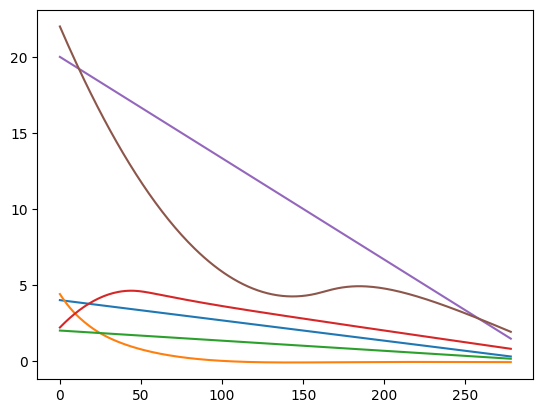

In [94]:
Xsim_m = mat_from_vec(Xhist)
Usim_m = mat_from_vec(Uhist)
Xref_m = mat_from_vec(Xref)
fig = plt.figure()
plot(Xref_m[1,1:NRUNS]) # z
plot(Xsim_m[1,1:NRUNS])
plot(Xref_m[2,1:NRUNS]) # z
plot(Xsim_m[2,1:NRUNS])
plot(Xref_m[3,1:NRUNS]) # z
plot(Xsim_m[3,1:NRUNS])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

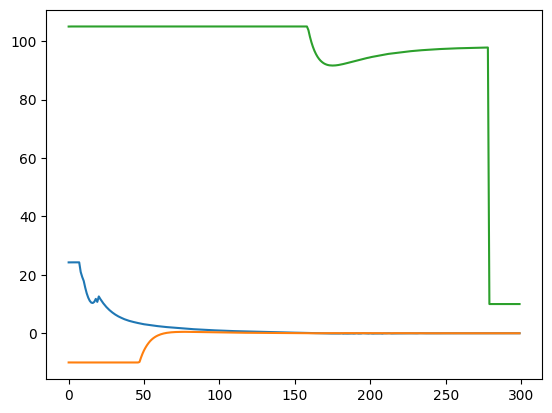

In [95]:
fig = plt.figure()
plot(Usim_m[1,:])
plot(Usim_m[2,:])
plot(Usim_m[3,:])
fig

In [96]:
print("max control = ", maximum(Usim_m[:, 1:NRUNS]), "\n")
print("min control = ", minimum(Usim_m[:, 1:NRUNS]), "\n")
print("max state = ", maximum(Xsim_m[2,:]))

max control = 104.99999946604792
min control = -9.999998280320094
max state = 4.620100125115891

tinyMPC is much faster than COSMOS

In [97]:
# Xsim_m = mat_from_vec(Xhist[1:end-Nh])
# Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
# e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
# @show traj_error = maximum(norm.(e_sim_m, Inf))
# display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
#              linestyle=[:solid :solid :solid :dash :dash :dash], 
#              title = "State Error History",
#              xlabel = "time (s)", ylabel = "x"))
# display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
#              title = "Input History",
#              xlabel = "time (s)", ylabel = "u"))
# display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
#              linestyle=[:solid :solid :solid :dash :dash :dash],
#              title = "State History",
#              xlabel = "time (s)", ylabel = "x"))